In [17]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
from scipy.io import savemat,loadmat
import numpy
import os

In [18]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [19]:
values=pd.read_csv('train.csv').values[:5000,-1]
# values
# dates=df.index.values
n_features=1 #特征数量

In [20]:
values1=values#取第一列数据        改成1就是对第二列数据预测     依次类推
values=values.reshape(-1,1)

In [21]:
values

array([[70],
       [49],
       [24],
       ...,
       [97],
       [54],
       [45]], dtype=object)

In [22]:
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(values)

In [23]:
scaled

array([[ 1.38470894],
       [ 0.10565025],
       [-1.41703867],
       ...,
       [ 3.02921297],
       [ 0.41018803],
       [-0.13797998]])

In [24]:
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values

In [25]:
values

array([[ 1.38470894,  0.10565025, -1.41703867, -1.78248401],
       [ 0.10565025, -1.41703867, -1.78248401,  0.77563337],
       [-1.41703867, -1.78248401,  0.77563337,  0.65381826],
       ...,
       [-0.38161021, -1.11250089, -1.6606689 ,  3.02921297],
       [-1.11250089, -1.6606689 ,  3.02921297,  0.41018803],
       [-1.6606689 ,  3.02921297,  0.41018803, -0.13797998]])

In [26]:
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

# 划分输入和输出,split into input and outputs
n_obs = n_in * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]

# 将数据转换为3D输入，[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3997, 3, 1) (3997, 1) (1000, 3, 1) (1000, 1)


In [27]:
N

3997

###   LSTM修改神经元个数就行，比如现在神经元是64

In [28]:
def lstm():
#建立模型
    inputs=Input(shape=(train_X.shape[1], train_X.shape[2]))
    lstm=LSTM(256, activation='relu',return_sequences=False)(inputs)
    outputs = Dense(1)(lstm)
    model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),loss='mse')
    model.compile(loss='mse',optimizer='Adam')
    model.summary()#展示模型结构
    return model
#运行
# 设计动态学习率下降模型
def scheduler(epoch):
    # 每隔10个epoch，学习率减小为原来的1/2
    if epoch % 10 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.5)
        print("lr changed to {}".format(lr * 0.5))
    return K.get_value(model.optimizer.lr)
reduce_lr = LearningRateScheduler(scheduler)

model = lstm()#建立模型
history = model.fit(train_X, train_y, epochs=60, batch_size=30, callbacks=[reduce_lr],validation_data=(test_X, test_y),verbose=2,
                    shuffle=False)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
134/134 - 1s - loss: 0.9907 - val_loss: 0.9539 - lr: 0.0010 - 1s/epoch - 10ms/step
Epoch 2/60
134/134 - 1s - loss: 1.0006 - val_loss: 0.9647 - lr: 0.0010 - 733ms/epoch - 5ms/step
Epoch 3/60
134/134 - 1s - loss: 1.0058 - val_loss: 0.9614 - lr: 0.0010 - 739ms/epoch - 6ms/step
Epoch 4/60
134/134 - 1s - loss:

In [29]:
#预测
yhat= model.predict(test_X)
# 对预测结果进行反归一化
inv_yhat = scaler.inverse_transform(yhat)
# 将真实列据进行反归一化
inv_y = scaler.inverse_transform(test_y)

32/32 [==============================] - 0s 7ms/step


In [30]:
# 计算RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(inv_y, inv_yhat))
print('Test R2: %.7f' % r2_score(inv_y, inv_yhat))

Test RMSE: 15.3916833
Test MAE: 12.2551353
Test R2: 0.0381041


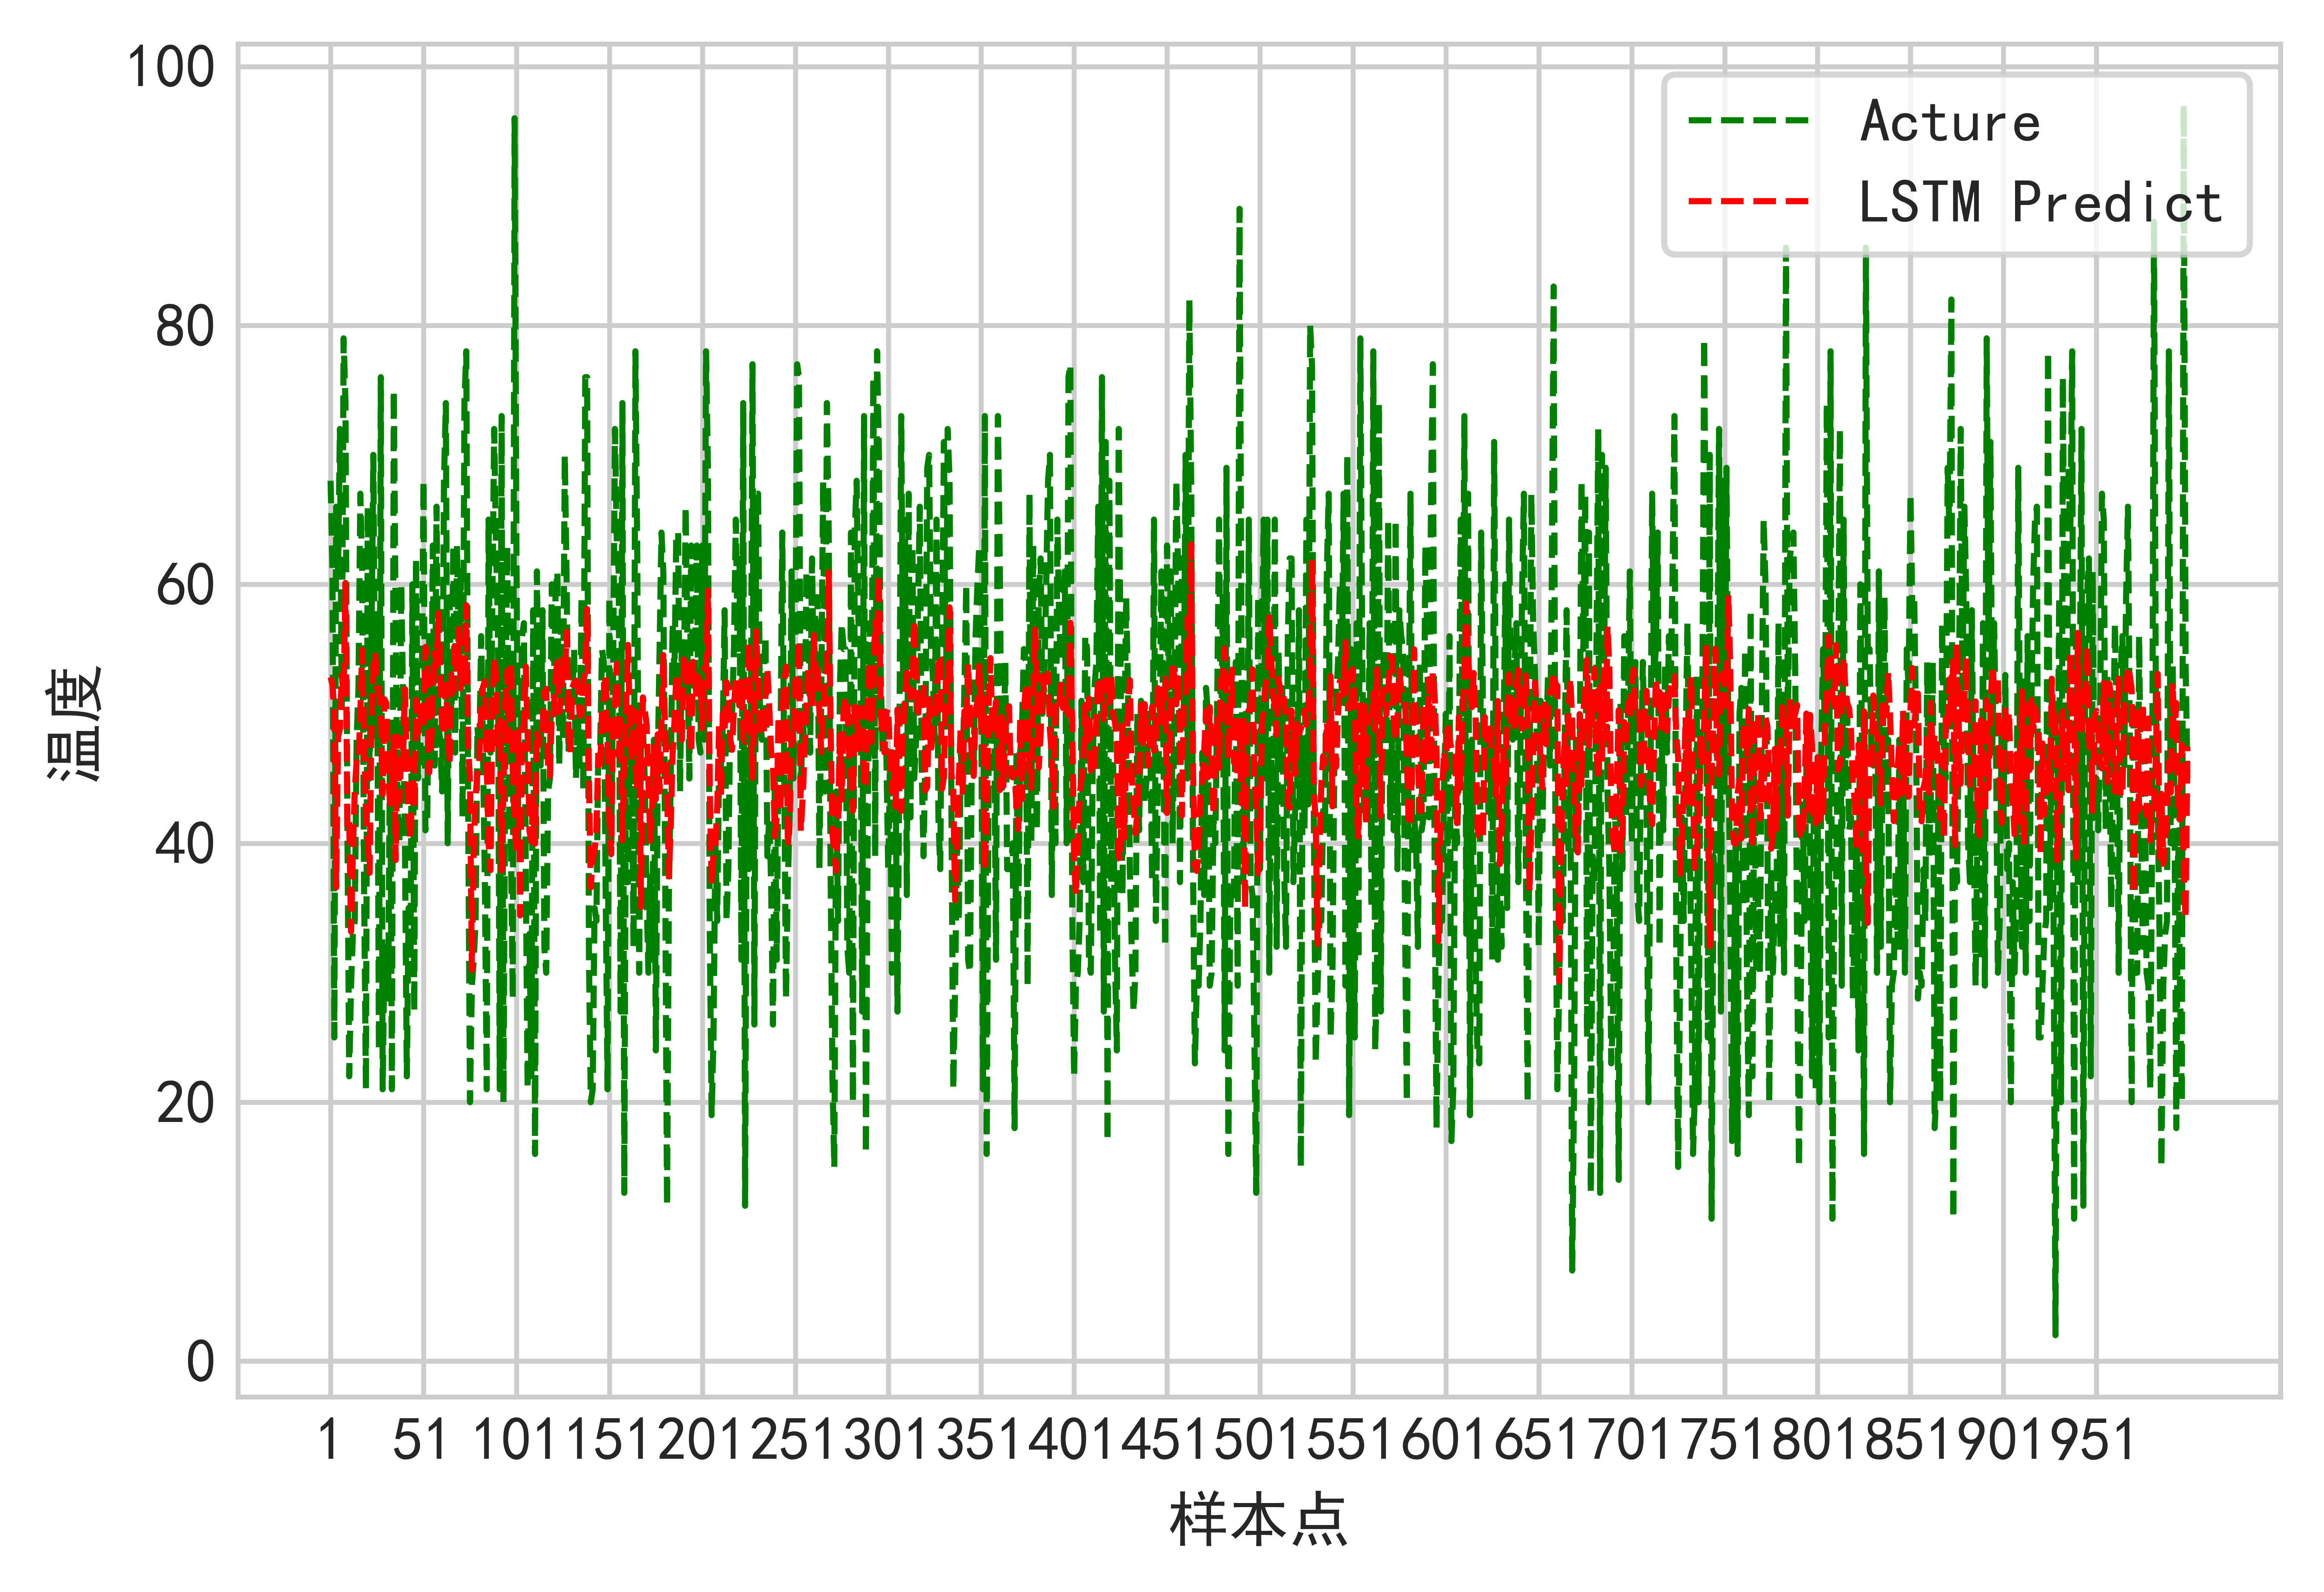

In [31]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(inv_yhat)+1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, inv_y, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, inv_yhat, color='red',linestyle="--",linewidth=1,label='LSTM Predict')
# plt.plot(x, inv_y,color='g',linewidth=1, label='真实值')
# plt.plot(x, inv_yhat,color='red',linestyle="--",linewidth=1,label='预测值')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("温度",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
plt.savefig('figure/LSTM预测结果图.png')
plt.show()

In [32]:
#保存预测结果
savemat('结果/lstm_result.mat',{'true':inv_y,'pred':inv_yhat})